# Pairs trading model based on stochastic optimal control

The model computes the optimal asset allocation $h_{t}^{*}$ by maximizing terminal payoff of the strategy:

$h_{t}^{*} := \underset{h(t)}{sup} \ \mathbb{E}\left[ \frac{1}{\gamma}V(T)^{\gamma}\right]$

subject to:

$dX_{t} = \kappa (\theta - X_t)dt + \eta dW_{t}^{x}$

and

$dV_{t} = \left[h_t(\kappa (\theta - X_t)+ \frac{1}{2}\eta^{2}+\rho \sigma \eta + r) \right]V_t dt + V_t \eta dW_{t}^{v} $

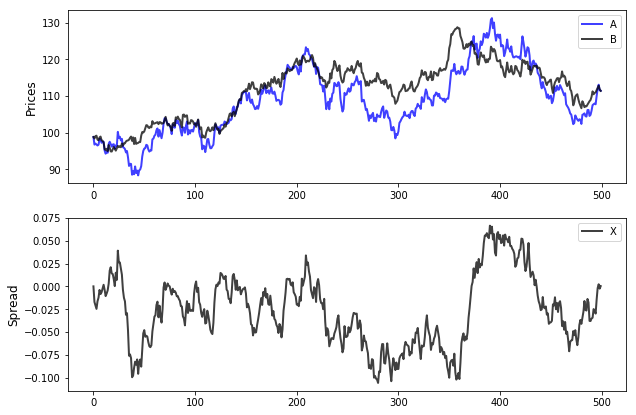

In [1]:
from src.simulation.simulate_cointegrated_assets import simulate_cointegrated_assets

N_sim   = 1
N_steps = 500
B_0     = 100
mu      = 0.05
kappa   = 5.5
theta   = 0.0
eta     = 0.15
sigma_B = 0.15
dt      = 1.0/250.0

A,B,X = simulate_cointegrated_assets(N_sim,N_steps,B_0,mu,kappa,theta,eta,sigma_B,dt)


import matplotlib.pyplot as plt

kws_A = {'label':'A','color':'blue' ,'alpha':0.75, 'lw': 2}
kws_B = {'label':'B','color':'black','alpha':0.75, 'lw': 2}
kws_X = {'label':'X','color':'black','alpha':0.75, 'lw': 2}

fig,ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(A[:,0],**kws_A)
ax[0].plot(B[:,0],**kws_B)
ax[0].set_ylabel('Prices',fontsize=12)
ax[0].legend()

ax[1].plot(X[:,0],**kws_X)
ax[1].set_ylabel('Spread',fontsize=12)
ax[1].legend()

plt.show()

## Parameter estimation

The strategy is dependent on the parameters $(\kappa, \theta, \eta, \rho )$ which describe the behavior of the spread:

$dX_{t} = \kappa (\theta - X_t)dt + \eta dW_{t}^{x}$


These parameters may be estimated using OLS.


In [2]:
from src.optimal_controls.ou_params import Ornstein_Uhlenbeck_Parameters
from src.optimal_controls.ou_spread_model_parameters import OU_Spread_Model_Parameters

# Estimate spread parameters
ou_params = Ornstein_Uhlenbeck_Parameters()
success   = ou_params.estimate_using_ols(A,B,dt)
if(success):
    print('OLS estimates are:')
    print(ou_params)
else:
    print('Failed to estimate model parameters!')
    
# Create trading model parameters
nominal  = 1000000
symbol_A = 'A'
symbol_B = 'B'
horizon  = None
risk_tol = -float(100)
max_leverage = 1

model_params = OU_Spread_Model_Parameters(nominal, symbol_A, symbol_B, horizon, risk_tol, max_leverage)


OLS estimates are:
Ornstein-Uhlenbeck Parameters: Kappa = 7.51, Theta = -0.03, Rho = -0.03, Eta = 0.15


/Users/juhahellen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Behavior of the strategy:

We solve the optimal allocation over $(t , X_t)$ grid in order to see how the model allocates capital on asset $A$ (allocation in asset $B$ is negative of the optimal allocation in asset $A$).

In [ ]:
from utils.plot_utils import plot_optimal_solution

plot_optimal_solution(X,ou_params,model_params)

### Effect of the spread level $X_t$
From the heatmap above we notice that when $X_t<0$ the optimal allocation $h_{t}^{*} > 0$. In other words, when the logarithmic price spread is negative the model suggest a long position in asset $A$. This makes sense since the spread is defined to be $X_t := ln(A_t) - ln(B_t)$ then $X_t < 0$ means that at time $t$ asset $A$ is under prices relative to asset $B$.  

### Effect of trading time $t$
We notice that as the remaining trading time $T-t \to 0$ the optimal allocation tends to become more conservative. In other words, when the algorithm is running out of time the positions tend towards zero automatically. 